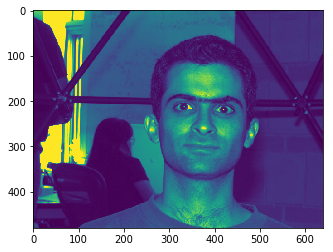

In [7]:
import numpy as np
import matplotlib.pyplot as plt

dataset = np.load('dataset.npy')
plt.imshow(dataset[0])
plt.show()